**Importar Librerías**

In [3]:
import pandas as pd
from pandas import datetime
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential    
from keras.layers import Dense
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate
from google.colab import files

**Preprocesing Data - Functions:**
1. Drop outliers.
2. Standardizing values.
3. Dealing with missing values. 
4. Feature Engineering - Differencing.
5. Feature Engineering - Computing Time Features.

In [4]:
# Generate multivariate features from n_steps of a group of parallel secuences.
def split_train_test(dataframe, month_from_test, station_file_number):
  train_dataset = list()
  test_dataset = list()
  for i in range(len(dataframe.index)):
    if int(dataframe.Fecha[i].split('/')[1]) == int(month_from_test):
      break
  
  train_dataset = dataframe.loc[:i-1,:]
  test_dataset = dataframe.loc[i:,:]

  file_name = "qHAWAX-VariablesContaminacion-Test (" + station_file_number + ").csv"
  test_dataset.to_csv(file_name) 
  #files.download(file_name)

  return train_dataset

In [5]:
#Remove Outliers:
def remove_outliers(dataframe):
  data = dataframe.copy()
  for (columnName, columnData) in data.iteritems():
    if (columnName != "Fecha" and columnName != "Latitud" and columnName != "Longitud"):
      feature = data[columnName]
      #Search for outliers:
      outliers = feature.between(feature.quantile(.05), feature.quantile(.995))
      index_names = data[~outliers].index
      #Replace outliers with word "NaN":
      data[columnName].loc[index_names] = np.nan
      #print(outliers.value_counts())
      #print(index_names)
  return data

In [6]:
#Computing Standard Vector.
from sklearn.preprocessing import StandardScaler
def standarized_vector(dataframe):
  data = dataframe.copy()
  data.drop(columns=['Latitud', 'Longitud', 'Fecha'], inplace=True)
  vector_scaler = StandardScaler()
  vector_scaler.fit_transform(data)
  return vector_scaler

In [7]:
#Standarizing Values.
def standarized_values(dataframe, vector_scaler):
  data = dataframe.copy()
  data.drop(columns=['Latitud', 'Longitud', 'Fecha'], inplace=True)
  df_standard_scale = pd.DataFrame(vector_scaler.transform(data))
  df_standard_scale = df_standard_scale.rename(columns={0: "CO (ug/m3)", 1: "H2S (ug/m3)", 2: "NO2 (ug/m3)", 3: "O3 (ug/m3)", 4: "PM10 (ug/m3)", 5: "PM2.5 (ug/m3)", 6: "SO2 (ug/m3)", 7: "Ruido (dB)", 8: "UV", 9: "Humedad (%)", 10: "Presion (hPa)", 11: "Temperatura (C)"})
  return df_standard_scale

In [8]:
#Interpolation of missing values:
def deal_missing_values(dataframe):
  data = dataframe.copy()
  for (columnName, columnData) in data.iteritems():
    feature = data[columnName]
    data[columnName] = feature.interpolate()
  return data

In [9]:
#Time differencing (t-1):
def differencing_transform(dataframe):
  data = dataframe.copy()
  data.drop(columns=['Latitud', 'Longitud', 'Fecha'], inplace=True)
  for (columnName, columnData) in data.iteritems():
    #data_log = np.log(data[columnName])
    data_dif_time = data[columnName]
    data[columnName] = data_dif_time - data_dif_time.shift(1)
  return data

In [10]:
# Generate multivariate features from n_steps of a group of parallel secuences.
def generate_time_features(dataframe, n_steps_in, n_steps_out):
  x = list()
  y = list()
  for i in range(len(dataframe.index)):
      end_step = i + n_steps_in
      out_end_ix = end_step + n_steps_out
      if end_step > len(dataframe.index)-1:
        break
      # Separate time feature values from time target values.
      x.append(dataframe.loc[i:end_step, :].values)
      y.append(dataframe.iloc[end_step:out_end_ix, :].values)
  return np.array(x), np.array(y)

In [ ]:
dataset = pd.read_csv("qHAWAX-VariablesContaminacion_1 (2).csv")
x, y = generate_time_features(dataset, 3, 3)

In [ ]:
dataset_time_diff = differencing_transform(dataset)

CO (ug/m3)


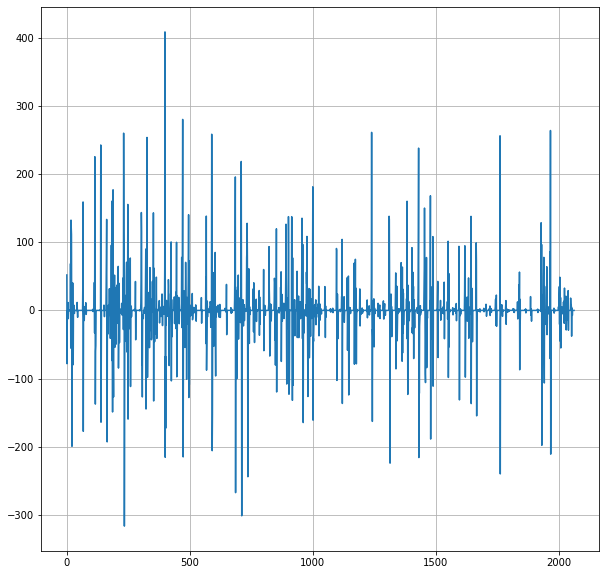

H2S (ug/m3)


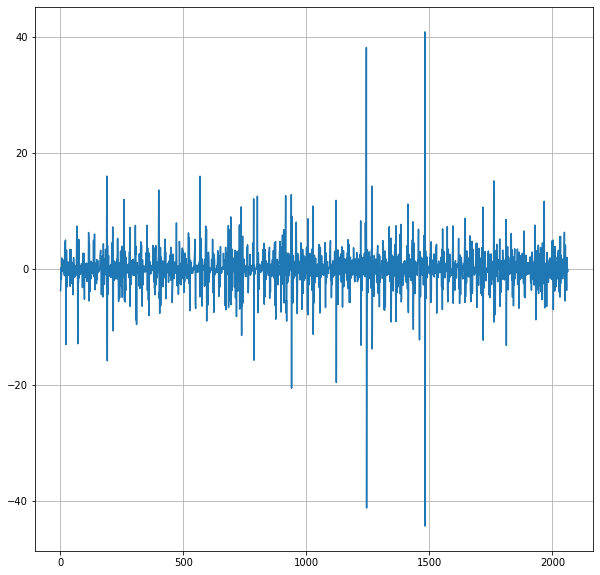

NO2 (ug/m3)


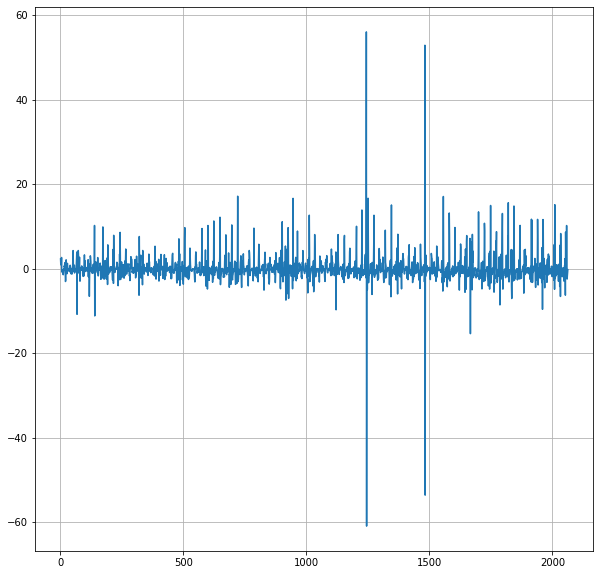

O3 (ug/m3)


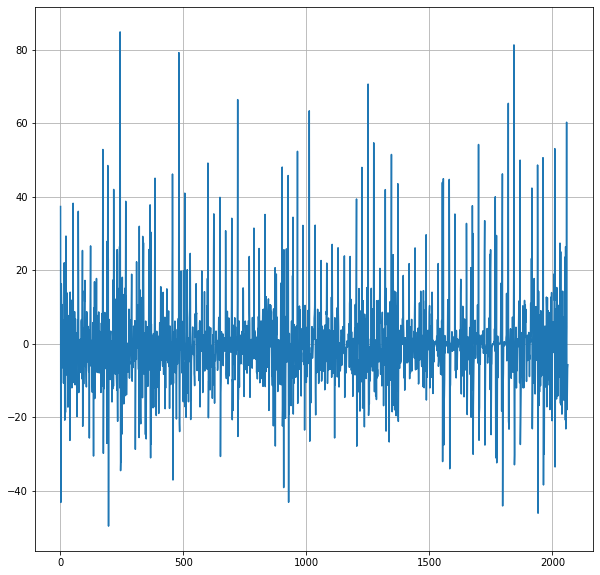

PM10 (ug/m3)


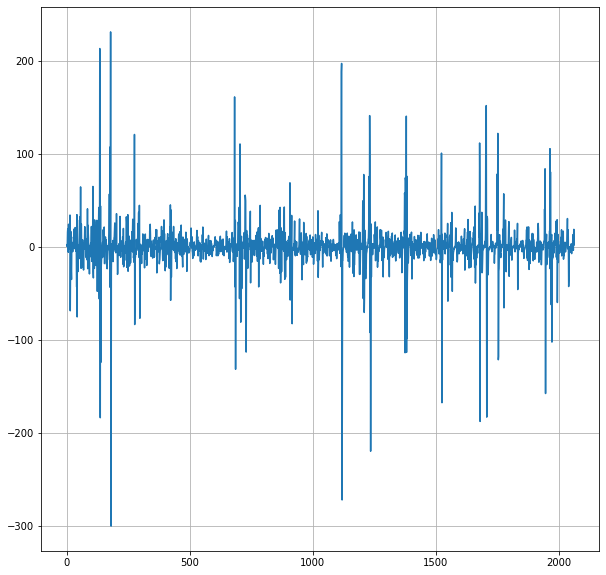

PM2.5 (ug/m3)


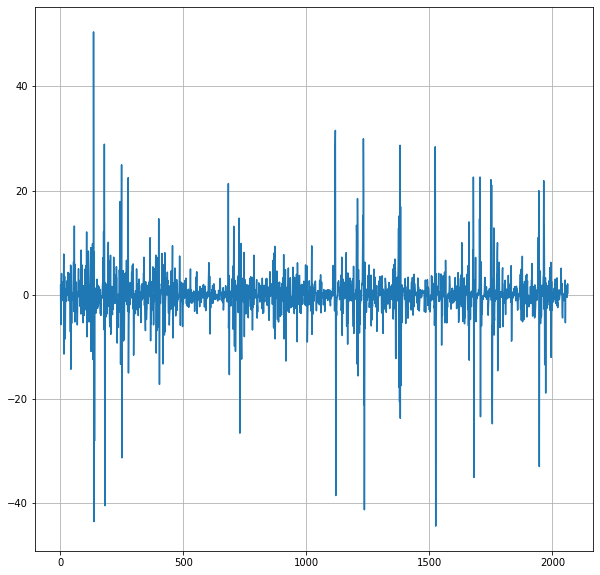

SO2 (ug/m3)


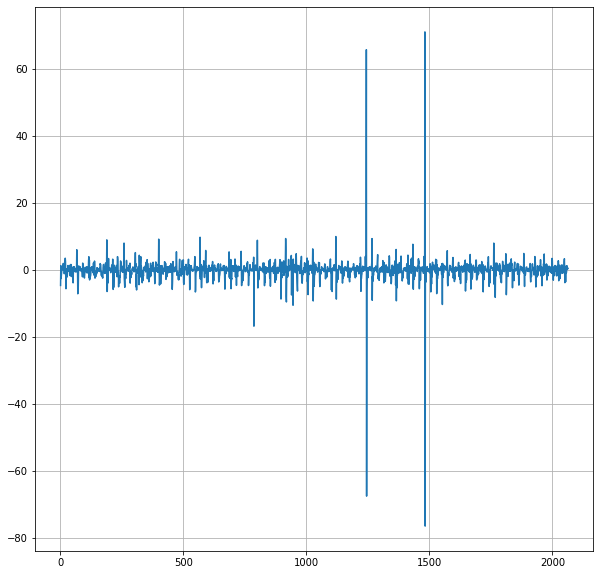

Ruido (dB)


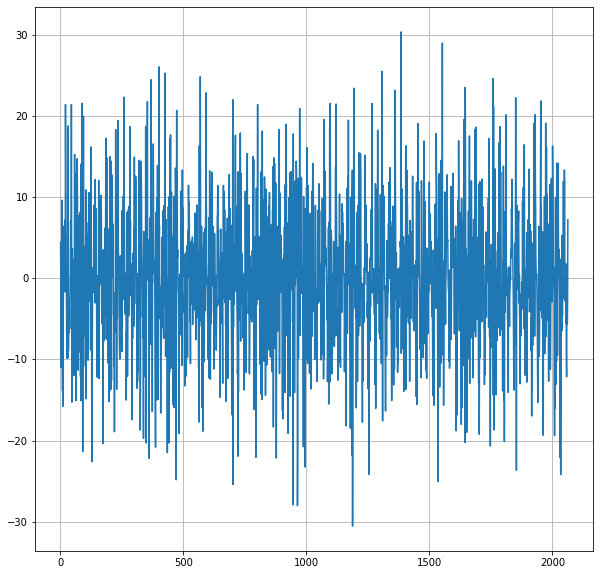

UV


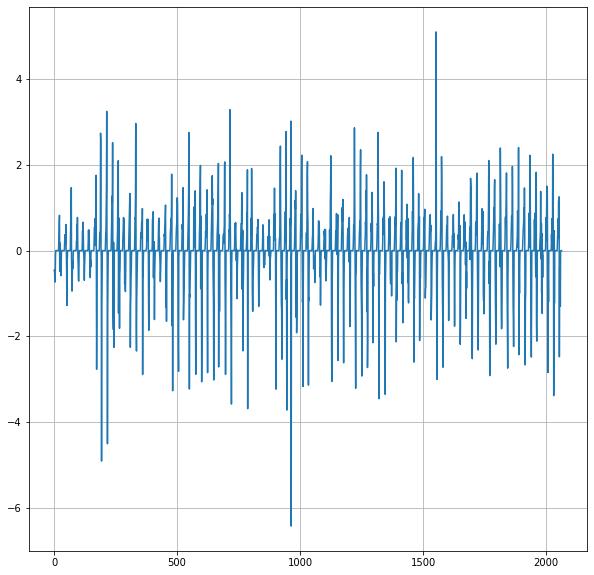

Humedad (%)


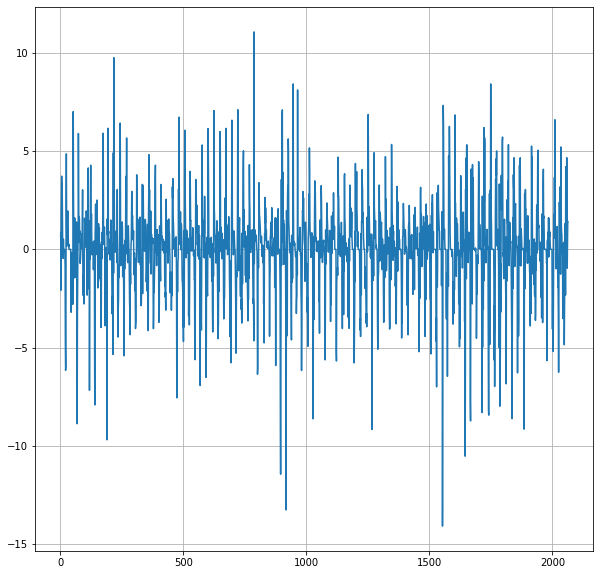

Presion (hPa)


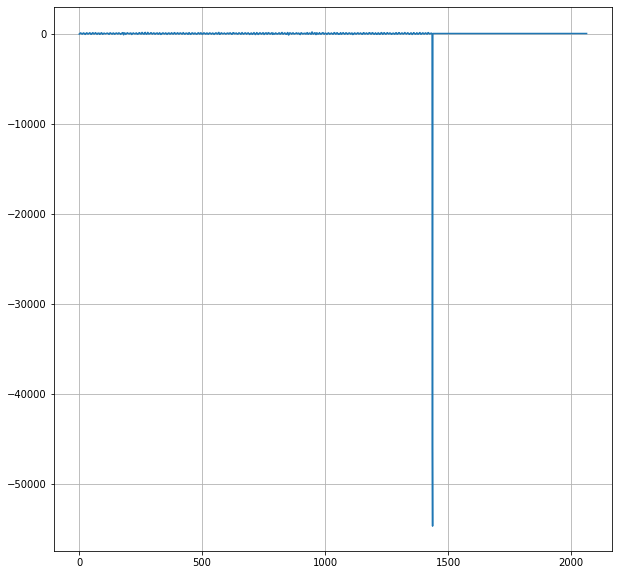

Temperatura (C)


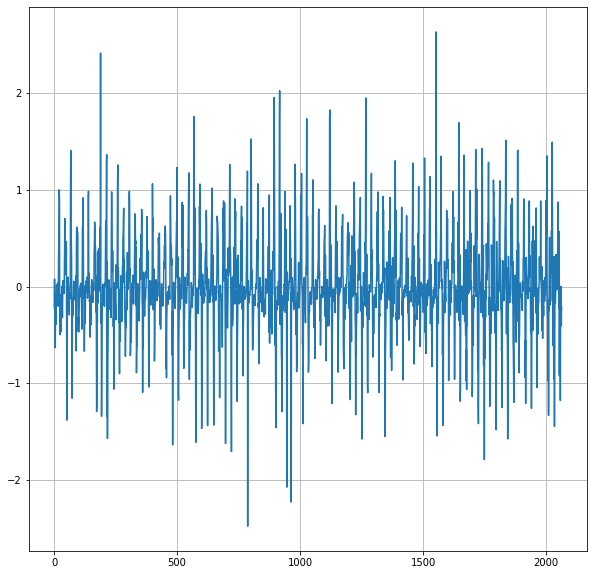

In [ ]:
for (columnName, columnData) in dataset_time_diff.iteritems():
  plt.figure()
  print(columnName)
  dataset_time_diff[columnName].plot(figsize=(10,10),grid =True)
  plt.show()

In [ ]:
y[0]

array([[0.0, 59.99100000000001, 72.62, 41.309, 19.173, 6.507000000000001,
        0.0, 50.994, 0.0, 95.273, -12.1030559999999, -76.9891659999995,
        99503.065, 21.886, '19/03/2020 03:00:00'],
       [0.0, 54.586000000000006, 75.041, 41.126999999999995, 14.806,
        5.617999999999999, 0.0, 51.141000000000005, 0.0, 95.944,
        -12.1030559999999, -76.9891659999995, 99487.252, 21.706,
        '19/03/2020 04:00:00'],
       [0.0, 49.082, 72.256, 41.165, 11.825999999999999, 5.275, 0.0,
        50.876000000000005, 0.0, 96.156, -12.1030559999999,
        -76.9891659999995, 99479.985, 21.693, '19/03/2020 05:00:00']],
      dtype=object)

In [ ]:
x[2]

array([[0.0, 61.008, 65.892, 41.56, 17.617, 6.255, 0.0, 51.2, 0.0,
        92.76899999999999, -12.1030559999999, -76.9891659999995,
        99544.585, 22.166999999999998, '19/03/2020 02:00:00'],
       [0.0, 59.99100000000001, 72.62, 41.309, 19.173, 6.507000000000001,
        0.0, 50.994, 0.0, 95.273, -12.1030559999999, -76.9891659999995,
        99503.065, 21.886, '19/03/2020 03:00:00'],
       [0.0, 54.586000000000006, 75.041, 41.126999999999995, 14.806,
        5.617999999999999, 0.0, 51.141000000000005, 0.0, 95.944,
        -12.1030559999999, -76.9891659999995, 99487.252, 21.706,
        '19/03/2020 04:00:00'],
       [0.0, 49.082, 72.256, 41.165, 11.825999999999999, 5.275, 0.0,
        50.876000000000005, 0.0, 96.156, -12.1030559999999,
        -76.9891659999995, 99479.985, 21.693, '19/03/2020 05:00:00']],
      dtype=object)

In [ ]:
vertical_stack = pd.DataFrame()
for i in range(n_stations):
  # Change name of file to read.
  station_file_number = str(i+1)
  station_file_name = "qHAWAX-VariablesContaminacion_1 (" + station_file_number + ").csv"
  # Read CSV file.
  dataset = pd.read_csv(station_file_name)
  vertical_stack = vertical_stack.append(dataset)
  vertical_stack.reset_index(drop=True)
  
standard_vector = standarized_vector(vertical_stack)

dataset = pd.read_csv("qHAWAX-VariablesContaminacion (2).csv")
a = standarized_values(dataset,standard_vector)
a.describe()

,CO (ug/m3),H2S (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM2.5 (ug/m3),SO2 (ug/m3),Ruido (dB),UV,Humedad (%),Presion (hPa),Temperatura (C)
count,5800.000000,5800.000000,5800.000000,5800.000000,5800.000000,5800.000000,5800.000000,5801.000000,5801.000000,5801.000000,5801.000000,5801.000000
mean,-0.770020,0.306386,0.729545,0.371415,0.005956,0.380977,-0.122951,-0.619688,-0.140180,0.110624,-0.038961,0.012710
std,0.166141,0.750307,2.398866,0.377976,0.444405,1.408941,0.010014,0.844313,0.010597,0.964343,1.031161,1.051695
min,-0.926506,-0.947985,-0.505546,-0.240769,-0.583609,-1.101928,-0.124638,-1.417004,-0.145885,-3.660863,-2.984574,-1.618934
25%,-0.920684,-0.171762,-0.052722,0.257723,-0.283864,-0.393757,-0.124638,-1.271473,-0.145885,-0.483340,0.316610,-0.787014
50%,-0.788990,0.259748,0.533496,0.311718,-0.116449,-0.014806,-0.124638,-0.923772,-0.145885,0.534245,0.321403,-0.308490
75%,-0.710608,0.609340,1.040016,0.395954,0.168583,0.699346,-0.124638,-0.275608,-0.137816,0.923251,0.325438,0.650417
max,1.048187,4.569596,89.327059,5.882225,4.826174,19.502489,0.200722,1.524471,-0.078378,0.928087,0.356252,4.409851


In [2]:
# Generate train time features dataset from all qHAWAX stations.
n_steps_in = 13
n_steps_out = 6
total_time_features = 0
total_time_targets = 0
n_stations = 10
month_from_test = 10

vertical_stack = pd.DataFrame()
for i in range(n_stations):
  # Change name of file to read.
  station_file_number = str(i+1)
  station_file_name = "qHAWAX-VariablesContaminacion_1 (" + station_file_number + ").csv"
  # Read CSV file.
  dataset = pd.read_csv(station_file_name)
  vertical_stack = vertical_stack.append(dataset)
  vertical_stack.reset_index(drop=True)
standard_vector = standarized_vector(vertical_stack)

for i in range(n_stations):
  # Change name of file to read.
  station_file_number = str(i+1)
  station_file_name = "qHAWAX-VariablesContaminacion_1 (" + station_file_number + ").csv"
  # Read CSV file.
  dataset = pd.read_csv(station_file_name)
  # Remove outliers.
  data_outliers = remove_outliers(train_dataset)
  # Deal with missing values.
  data_miss = deal_missing_values(data_outliers)
  # Time Differences.
  dataset_time_diff = differencing_transform(data_miss)
  # Stadarizing values.
  data_processed = standarized_values(dataset_time_diff, standard_vector)

  # Generate Train time features from time windowing process.
  x_time_features, y_time_targets = generate_time_features(data_processed, n_steps_in, n_steps_out)

  # Split Train/Test.
  train_dataset = split_train_test(dataset, month_from_test, station_file_number)

  if (i == 0):
    total_time_features = x_time_features
    total_time_targets = y_time_targets
  else:
    total_time_features = np.concatenate((total_time_features, x_time_features), axis=0)
    total_time_targets = np.concatenate((total_time_targets, y_time_targets), axis=0)

FileNotFoundError: ignored

In [ ]:
print("Size of time features data array:", total_time_features.shape)
print("Size of time target data array:", total_time_targets.shape)

Size of time features data array: (35335, 13, 12)
Size of time target data array: (35335,)


In [ ]:
x_time_features.dtype

dtype('float64')

In [ ]:
y_time_targets.dtype

dtype('O')

In [ ]:
n_output = total_time_targets[0].shape[0] * total_time_targets[0].shape[1]   # numero de salidas
y_train = total_time_targets.reshape((total_time_targets.shape[0], n_output))

ValueError: ignored

**NN Architecture:**
- Multi-variate.
- Multiple steps.

In [ ]:
# Aplana las secuencias de entrada
n_input = total_time_features.shape[1] * total_time_features.shape[2] # numero de entradas
x_train = total_time_features.reshape((total_time_features.shape[0], n_input))

n_output = total_time_targets[0].shape[0] * total_time_targets[0].shape[1] # numero de salidas
y_train = total_time_targets.reshape((total_time_targets.shape[0], n_output))

#Topología de CNN
modelo = Sequential()
modelo.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, 1)))
modelo.add(MaxPooling1D(pool_size=2))
modelo.add(Flatten())
modelo.add(Dense(50, activation='relu'))
modelo.add(Dense(n_output))
modelo.compile(loss='mse', optimizer='adam')

# entrena el modelo MLP con la la data de entrenamiento generada
modelo.fit(x_train, y_train, epochs=1000, verbose=0)

# muestra un resumen de la topologia del modelo
modelo.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               4900      
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1212      
Total params: 6,112
Trainable params: 6,112
Non-trainable params: 0
_________________________________________________________________
